In [1]:
from data import*
from regression import*

# %matplotlib inline
from pycaret.regression import*
from sklearn.metrics import mean_squared_error


Using TensorFlow backend.


In [2]:
win_size = 1
step = None

synth_data = DATA( dataset_name='synth', features=['synth_vind_1', 'synth_vind_2'], target='center_1')
train_synth_data, test_synth_data = synth_data.split(ratio=.9)
train_synth_data_sg_df = train_synth_data.segment(win_size, step=step, as_df=True)
test_synth_data_sg_df = test_synth_data.segment(win_size, step=step, as_df=True)

In [3]:
exp_reg = setup(train_synth_data_sg_df,
                train_size = .7,
                target = 'target', 
#                 normalize = True, 
                silent = True,
                session_id = 20
                )   


Setup Succesfully Completed!


,Description,Value
0,session_id,20
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(300600, 3)"
4,Missing Values,False
5,Numeric Features,2
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [4]:
model = tune_model('catboost')

IntProgress(value=0, description='Processing: ', max=16)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:56:50
Status,. . . . . . . . . . . . . . . . . .,Tuning Hyperparameters
ETC,. . . . . . . . . . . . . . . . . .,Calculating ETC


,MAE,MSE,RMSE,R2,RMSLE,MAPE


In [49]:
plot_model(model, plot='error')
# plot_model(model, plot='feature')

NRMSE = % 0.5824227340933653


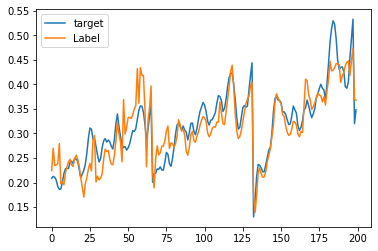

In [41]:
prediction = predict_model(model, data=test_synth_data_sg_df)
nrmse = mean_squared_error(prediction.target, prediction.Label) / np.nanmean(prediction.target) * 100
print('NRMSE = %', nrmse)

idx = np.arange(0,200)
ax = prediction.loc[idx,:].plot(y='target')
prediction.loc[idx,:].plot(y='Label', ax=ax)

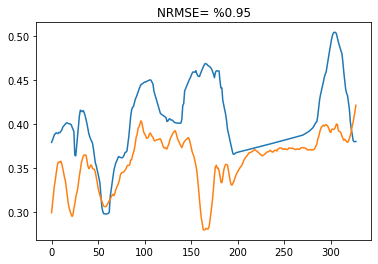

In [50]:
# meas_dataset = DATA( dataset_name='arduino', features=['synth_vind_1', 'synth_vind_2'], target='center_1')
meas_dataset = DATA( dataset_name='arduino', features=['vind_1', 'vind_2'], target='center_1')

# meas_dataset_mtx = meas_dataset.mtx(Nt_mtx='min')
meas_dataset_sg_df_list = meas_dataset.segment(win_size, step=1, as_df=True)

data = meas_dataset_sg_df_list[7]
prediction = predict_model(model, data=data)

y_true = prediction.target.to_numpy()
y_pred = prediction.Label.to_numpy()
y_pred = signal.savgol_filter(y_pred, window_length=7, polyorder=1, axis=0)             

nrmse = round( mean_squared_error(y_true, y_pred) / np.nanmean(y_true) * 100, 2)

plt.plot(y_true)
plt.plot(y_pred)
plt.title( 'NRMSE= %' + str(nrmse))
plt.show()


In [46]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.032200,0.001900,0.043000,0.806000,0.031700,0.104300
1,Light Gradient Boosting Machine,0.032600,0.001900,0.043800,0.799500,0.032200,0.105600
2,Random Forest,0.033100,0.002000,0.044400,0.793600,0.032700,0.107400
3,Extra Trees Regressor,0.033300,0.002000,0.044700,0.791200,0.032900,0.107700
4,Extreme Gradient Boosting,0.034000,0.002100,0.045300,0.784600,0.033400,0.110200
5,Gradient Boosting Regressor,0.034100,0.002100,0.045400,0.784400,0.033400,0.110300
6,K Neighbors Regressor,0.037000,0.002500,0.049700,0.741100,0.036700,0.122800
7,AdaBoost Regressor,0.040700,0.002600,0.051300,0.724500,0.037700,0.129200
8,Support Vector Machine,0.043900,0.002900,0.053600,0.699100,0.039700,0.138500
9,Ridge Regression,0.043600,0.003200,0.056700,0.663600,0.041800,0.141500


In [12]:
# 

In [33]:
x = meas_dataset.X[0]
y = meas_dataset.Y[0]
nt = np.shape(x)[0]
Nt = 350

xx = np.pad( x, ((0,Nt-nt),(0,0)),'constant')
yy = np.pad( y, ((Nt-nt),(0)),'constant')
np.shape(yy)

(350,)